<a href="https://colab.research.google.com/github/Olin-RoboSys/test-colab/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Section 1: Images as Arrays

We define how images are represented as arrays

Import relevant Python packages

In [91]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

Load and display an image

In [92]:
path_to_image = 'orange.png'

# read the image from the directory
img = cv.imread(path_to_image)

In [93]:
# display the image array

print(img)
print(img[0,0])

[[[16 30  6]
  [42 54 36]
  [43 54 46]
  ...
  [ 1 29  0]
  [ 0 28  0]
  [ 0 28  0]]

 [[30 58 29]
  [34 54 35]
  [54 70 59]
  ...
  [ 0 27  1]
  [ 0 28  0]
  [ 0 28  0]]

 [[ 0 29  1]
  [15 46 25]
  [53 71 58]
  ...
  [ 0 27  1]
  [ 0 28  0]
  [ 0 28  0]]

 ...

 [[50 82 57]
  [51 88 62]
  [55 98 71]
  ...
  [50 67 34]
  [55 71 40]
  [53 71 40]]

 [[53 87 63]
  [51 87 63]
  [57 98 71]
  ...
  [51 66 34]
  [55 71 40]
  [53 71 40]]

 [[60 96 74]
  [60 96 72]
  [58 98 70]
  ...
  [51 66 34]
  [55 70 42]
  [56 76 47]]]
[16 30  6]


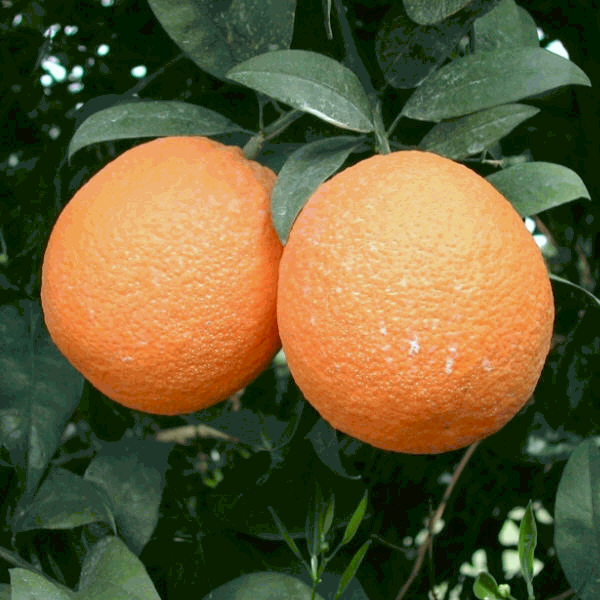

In [94]:
# display the image
cv2_imshow(img)

Image data shape: (15, 15, 3)


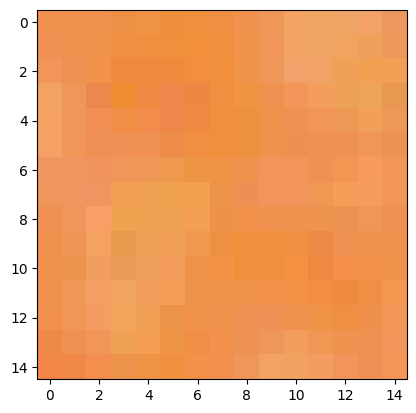

In [95]:
# cropping the array

img_cropped = img[285:300, 285:300].copy()
img_cropped_rgb = cv.cvtColor(img_cropped, cv.COLOR_BGR2RGB)
plt.imshow(img_cropped_rgb)
print(f'Image data shape: {img_cropped_rgb.shape}')

In [96]:
# inspect the data type and shape
print('OpenCV image data type:', type(img))
print(f'Image data shape: {img.shape}')

OpenCV image data type: <class 'numpy.ndarray'>
Image data shape: (600, 600, 3)


In [97]:
# convert from BGR -> RGB for sake of matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

3


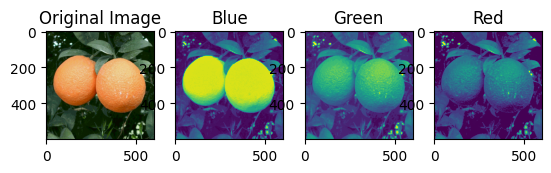

In [98]:
# split image into respective channels

channels = cv.split(img_rgb)
print(len(channels))
titles = ['Original Image', 'Blue', 'Green', 'Red']

plt.subplot(1,4,1)
plt.imshow(img_rgb), plt.title(titles[0])

for i in range(len(channels)):
    plt.subplot(1,4,i+2)
    plt.imshow(channels[i])
    plt.title(titles[i+1])

plt.show()

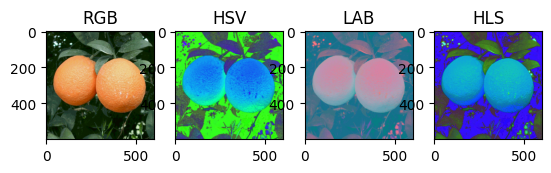

In [99]:
# change to different color spaces

img_hsv = cv.cvtColor(img_rgb, cv.COLOR_RGB2HSV)
img_lab = cv.cvtColor(img_rgb, cv.COLOR_RGB2LAB)
img_hls = cv.cvtColor(img_rgb, cv.COLOR_RGB2HLS)

titles = ['RGB', 'HSV', 'LAB', 'HLS']
imgs = [img_hsv, img_lab, img_hls]

plt.subplot(1,4,1)
plt.imshow(img_rgb), plt.title(titles[0])

for i in range(len(imgs)):
    plt.subplot(1,4,i+2)
    plt.imshow(imgs[i])
    plt.title(titles[i+1])

plt.show()

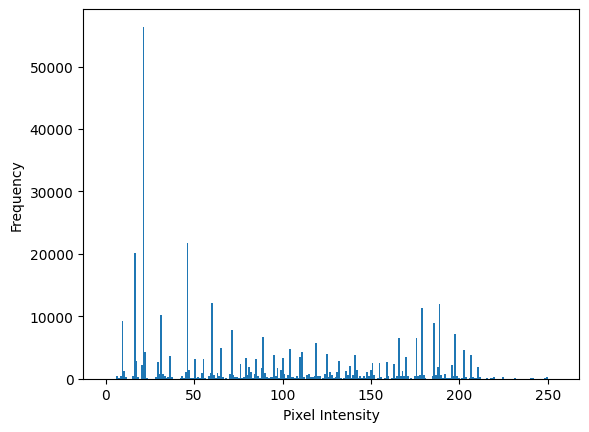

In [100]:
# Evaluate image histograms
# reference: https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html

# convert image to grayscale
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# cv2_imshow(img_gray)

histSize = 256
histRange = (0, 255)
# hist = cv.calcHist([img_gray], [0], None, [histSize], histRange)
# plt.plot(hist)

plt.hist(img_gray.flatten(), bins=histSize, range=histRange, alpha=1)
# plt.title('Histogram of Grayscale Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


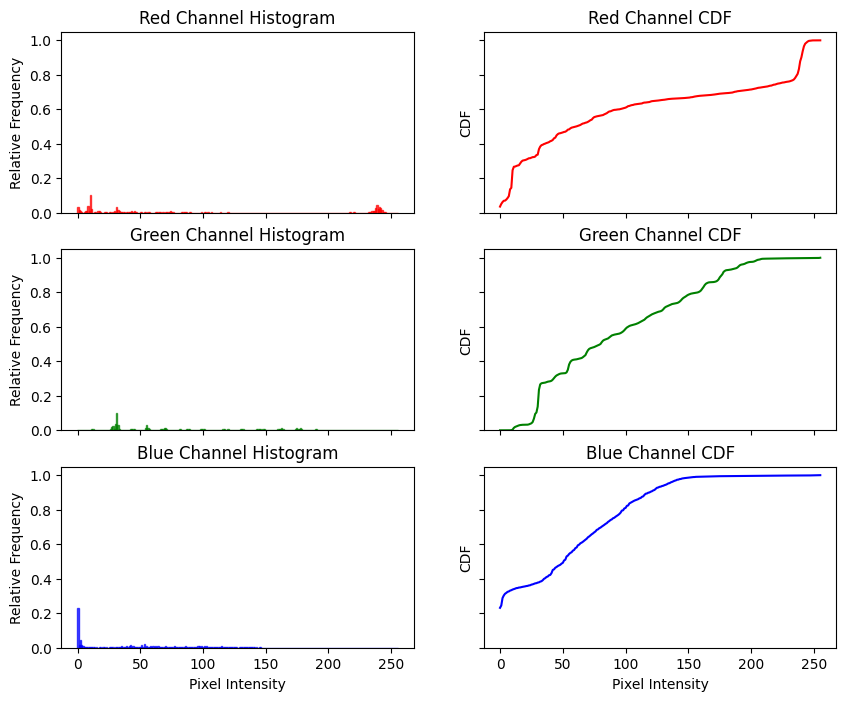

In [101]:
# plot histogram for all three channels of RGB image

# Initialize figure and axis
fig, axes = plt.subplots(3, 2, figsize=(10, 8), sharex='col', sharey='row')
colors = ['red', 'green', 'blue']
channel_names = ['Red', 'Green', 'Blue']

for i, color in enumerate(colors):
    # Calculate the histogram for each channel
    hist, bins = np.histogram(img_rgb[..., i], bins=256, range=(0, 256))

    # Normalize the histogram to get relative frequency
    hist = hist / hist.sum()

    # Calculate the CDF
    cdf = np.cumsum(hist)

    # Plot the histogram
    axes[i, 0].bar(bins[:-1], hist, width=1, edgecolor=color, color=color, alpha=0.7)
    axes[i, 0].set_title(f'{channel_names[i]} Channel Histogram')
    axes[i, 0].set_ylabel('Relative Frequency')

    # Plot the CDF
    axes[i, 1].plot(bins[:-1], cdf, color=color)
    axes[i, 1].set_title(f'{channel_names[i]} Channel CDF')
    axes[i, 1].set_ylabel('CDF')

# Set common labels
axes[-1, 0].set_xlabel('Pixel Intensity')
axes[-1, 1].set_xlabel('Pixel Intensity')

# plt.tight_layout()
plt.show()

## Section 2: Image Enhancement

### Histogram Equalization


In [110]:
# Histogram equalization
# references:
# - https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# - https://www.sci.utah.edu/~acoste/uou/Image/project1/Arthur_COSTE_Project_1_report.html

path_to_image = 'orange2.jpg'

# read the image from the directory
img = cv.imread(path_to_image)

# cv2_imshow(img)
img.shape

(360, 640, 3)

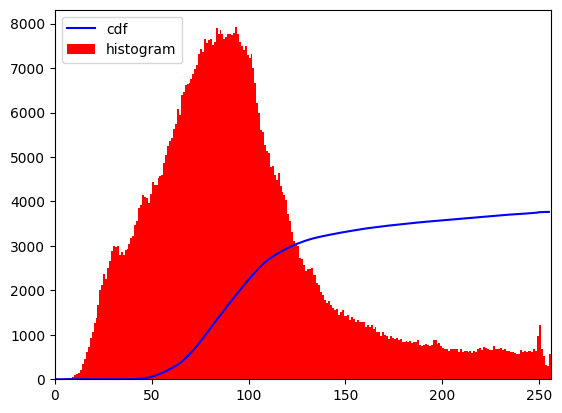

In [111]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

hist,bins = np.histogram(img_gray.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

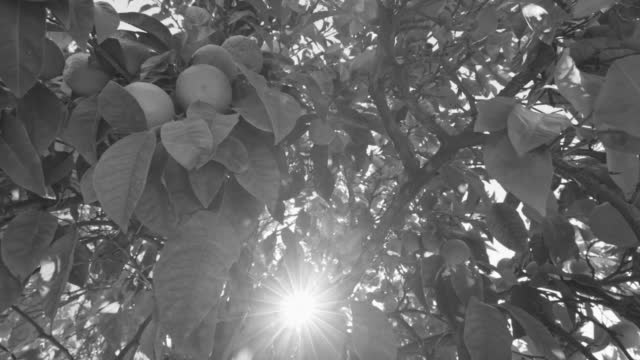

In [112]:
cv2_imshow(img_gray)

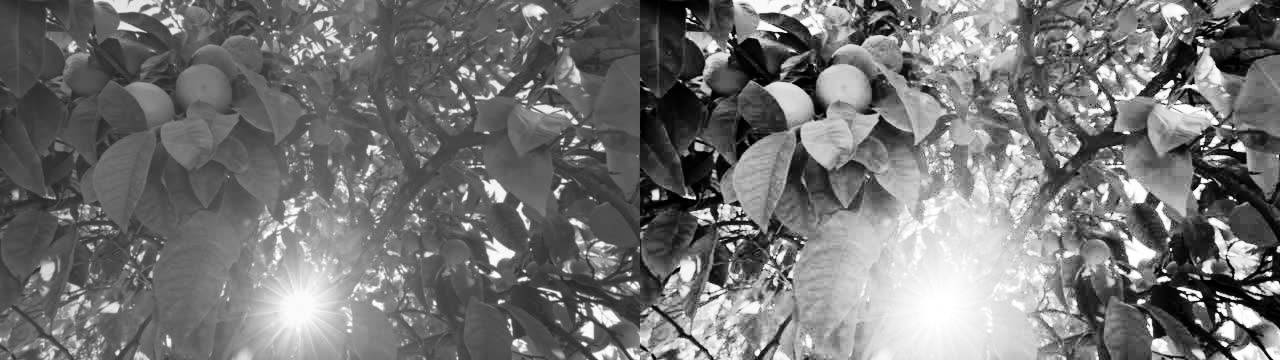

In [119]:
dst = cv.equalizeHist(img_gray)
res = np.hstack((img_gray, dst)) #stacking images side-by-side
cv2_imshow(res)

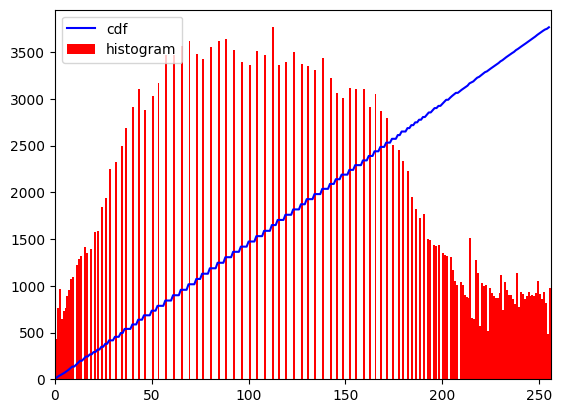

In [121]:
hist, bins = np.histogram(dst.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(dst.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

### Filtering

## Section 3: Segmentation

### Pixel-Wise Segmentation

1. Threshold-based using a manual approach

2. Otsu thresholding

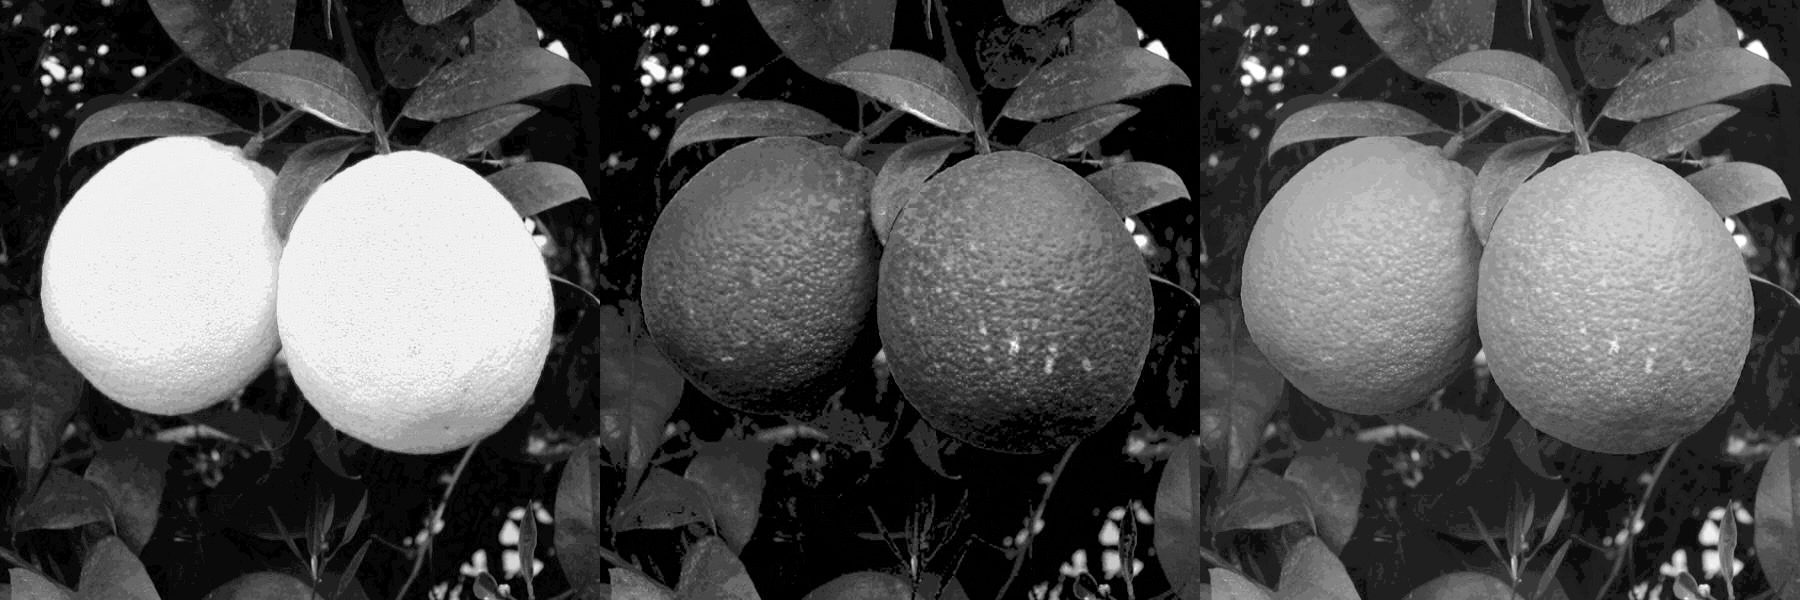

In [137]:
# Manual approach

path_to_image = 'orange.png'

# read the image from the directory
img = cv.imread(path_to_image)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

red, blue, green = cv.split(img_rgb)
res = np.hstack((red, green, blue))
cv2_imshow(res)

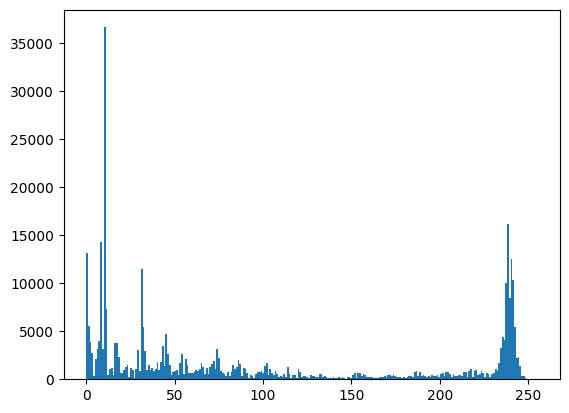

In [138]:
# get the histogram

plt.hist(red.flatten(), bins=256)
plt.show()

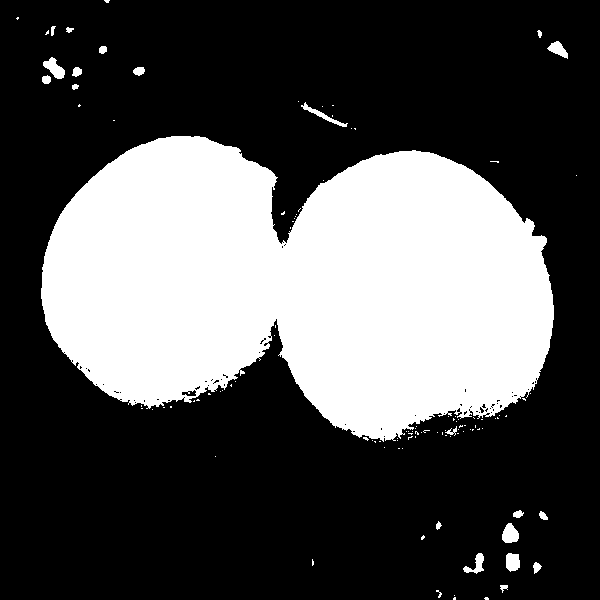

In [147]:
mask = red > 160
# cv2_imshow(mask)
mask = mask.astype(np.uint8) * 255
cv2_imshow(mask)

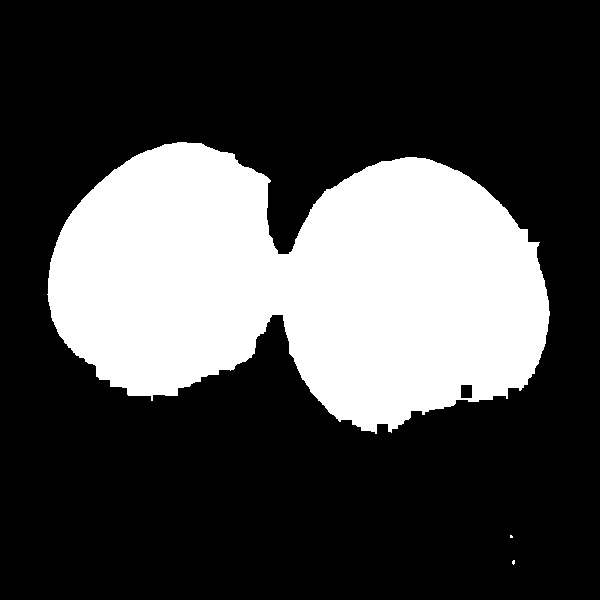

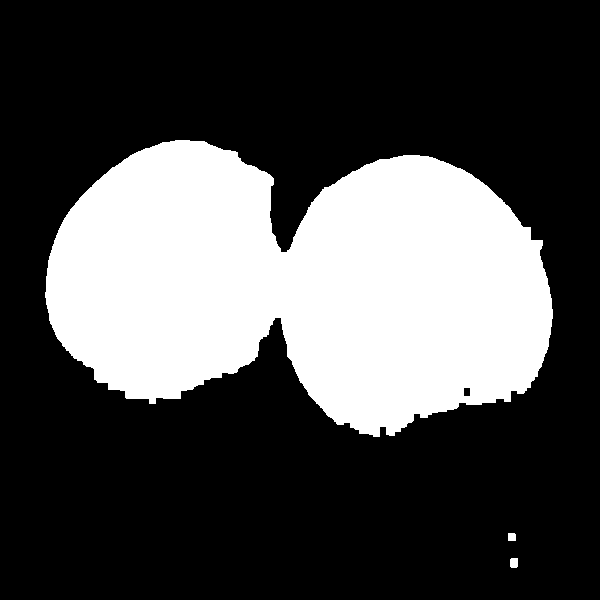

In [164]:
# erosion
kernel = np.ones((6,6), np.uint8)
mask_eroded = cv.erode(mask, kernel, iterations=2)
cv2_imshow(mask_eroded)

# dilation
mask_dilated = cv.dilate(mask_eroded, kernel, iterations=1)
cv2_imshow(mask_dilated)

# opening
opening = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
# cv2_imshow(opening)

In [165]:
# find contours

# im2, contours, hierarchy = cv.findContours(mask_dilated, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

ValueError: not enough values to unpack (expected 3, got 2)